# Домашняя работа 

В этой работы мы будем учиться предсказывать зарплату data scientist-ов в зависимочти от ряда факторов с помощью градиентоного бустинга

Цель домашней работы научиться предсказывать зарплаты (salary_in_usd) по ряды факторов 

work_year: The number of years of work experience in the field of data science.

experience_level: The level of experience, such as Junior, Senior, or Lead.

employment_type: The type of employment, such as Full-time or Contract.

job_title: The specific job title or role, such as Data Analyst or Data Scientist.

salary: The salary amount for the given job.

salary_currency: The currency in which the salary is denoted.

salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

employee_residence: The country or region where the employee resides.

remote_ratio: The percentage of remote work offered in the job.

company_location: The location of the company or organization.

company_size: The company’s size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn. preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import catboost
from catboost import CatBoostRegressor

import xgboost
from xgboost.sklearn import XGBRegressor

import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor

import shap

In [2]:
df = pd.read_csv("ds_salaries.csv")

In [3]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.2 балла)

Разделите выборку на train, val, test (80%, 10%, 10%) в качестве таргета выберите salary_in_usd, удалите из признаков (salary) чтобы избежать лика в данных.

In [4]:
y = df["salary_in_usd"]
X = df.drop(["salary_in_usd", "salary"], axis=1)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=42)

In [5]:
print(np.array([X_train.size, X_val.size, X_test.size])/np.sum(np.array([X_train.size, X_val.size, X_test.size])))

[0.79174434 0.1081225  0.10013316]


## Задание 2 (0.3 балла)

Обучите модель линейной регресии и оцените её качество через mape и rmse

In [6]:
cat = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", 
                        "company_location", "company_size"]
ohe = OneHotEncoder(handle_unknown='ignore')
feat = pd.DataFrame(ohe.fit_transform(X[cat]).toarray(), columns=ohe.get_feature_names_out())
X_ohe = X.copy()
X_ohe = X_ohe.drop(cat, axis=1)
X_ohe.reset_index(drop=True, inplace=True)
feat.reset_index(drop=True, inplace=True)
X_ohe = pd.concat([X_ohe, feat], axis=1)
feat = pd.DataFrame(ohe.transform(X_test[cat]).toarray(), columns=ohe.get_feature_names_out())
X0 = X_test.drop(cat, axis=1)
X0.reset_index(drop=True, inplace=True)
feat.reset_index(drop=True, inplace=True)
X_test_ohe = pd.concat([X0, feat], axis=1)

In [7]:
cat = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", 
                        "company_location", "company_size"]
le = LabelEncoder()
X_le = X.copy()
X_test_le = X_test.copy()
for i in cat:
     X_le[i] = le.fit_transform(X[i])
     X_test_le[i] = le.fit_transform(X_test[i])

In [8]:
cat = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", 
                        "company_location", "company_size"]
te = TargetEncoder()
X_te= pd.DataFrame(te.fit_transform(X, y), columns=te.get_feature_names_out())
X_test_te= pd.DataFrame(te.transform(X_test), columns=te.get_feature_names_out())

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [9]:
lr = LinearRegression()
lr.fit(X_le, y)
y_pred = lr.predict(X_test_le)
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred)**0.5, 2)}")

MAPE: 0.66, RMSE: 106200.39


## Задание 3 (0.3 балла)

Обучите модель бустинга выберите любую из трех библиотек catboost, xgboost, lightgbm и оцените её качество через mape и rmse

In [10]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(X_ohe, y)
y_pred = xgb.predict(X_test_ohe)
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred)**0.5, 2)}")

MAPE: 0.38, RMSE: 49318.38


In [11]:
d = dict()
d["xgb"] = []
d["gbm"] = []
d["cat"] = []

In [12]:
d["xgb"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

лучше, чем линейная регрессия, но ошибка все равно большая

## Задание 4 (0.6 балла)

Далее предобработайте категориальные признаки с помощью onehot кодирования, labelencoder и счетчиков (mean target encoding) сравните качество трёх моделей бустинга (catboost, xgb, lgbm) с помощью mape и rmse. Какие выводы можно сделать? Выберите для каждой из моделей лучшее кодирование категориальных признаков - в дальнейшем будем работать только с ним.

In [13]:
gbm = lgb.LGBMRegressor(objective="poisson", verbose=0, random_state=42)
gbm.fit(X_ohe, y)
y_pred = gbm.predict(X_test_ohe)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [14]:
d["gbm"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [15]:
cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(X_ohe, y, verbose=False)
y_pred = cat.predict(X_test_ohe)

In [16]:
d["cat"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [17]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(X_le, y)
y_pred = xgb.predict(X_test_le)

In [18]:
d["xgb"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [19]:
gbm = lgb.LGBMRegressor(objective="poisson", verbose=0, random_state=42)
gbm.fit(X_le, y)
y_pred = gbm.predict(X_test_le)

In [20]:
d["gbm"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [21]:
cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(X_le, y, verbose=False)
y_pred = cat.predict(X_test_le)

In [22]:
d["cat"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [23]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(X_te, y)
y_pred = xgb.predict(X_test_te)

In [24]:
d["xgb"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [25]:
gbm = lgb.LGBMRegressor(objective="poisson", verbose=0, random_state=42)
gbm.fit(X_te, y)
y_pred = gbm.predict(X_test_te)

In [26]:
d["gbm"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [27]:
cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(X_te, y, verbose=False)
y_pred = cat.predict(X_test_te)

In [28]:
d["cat"].append((round(mean_absolute_percentage_error(y_test, y_pred), 2), round(mean_squared_error(y_test, y_pred)**0.5, 2)))

In [29]:
pd.DataFrame.from_dict(d, orient='index', columns=["ohe", "le", "te"])

,ohe,le,te
xgb,"(0.38, 49318.38)","(0.66, 108459.92)","(0.4, 51333.65)"
gbm,"(0.4, 50480.47)","(0.62, 94030.12)","(0.39, 50218.08)"
cat,"(0.37, 49585.84)","(0.87, 137893.23)","(0.39, 68877.07)"


для XGBRegressor лучшее кодирование: OneHotEncoder, 
для LGBMRegressor лучшее кодирование: OneHotEncoder, 
для CatBoostRegressor лучшее кодирование: OneHotEncoder, качество на всех моделях с OneHotEncoder примерно одинаковое

## Задание 5 (0.6 балла)

Покажите, где ошибаются ваши модели. Выведите топ 20 примеров с наибольшей ошибкой для каждой модели. Проанализируете их, постарайтесь выделить группы с причинами ошибок в моделе. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [30]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(X_ohe, y)
y_pred_xgb = xgb.predict(X_test_ohe)


gbm = lgb.LGBMRegressor(verbose=0, objective="poisson", random_state=42)
gbm.fit(X_ohe, y)
y_pred_gbm = gbm.predict(X_test_ohe)


cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(X_ohe, y, verbose=False)
y_pred_cat = cat.predict(X_test_ohe)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [31]:
(ind, val) = (abs(y_pred_xgb - y_test).index, abs(y_pred_xgb - y_test).values)
ind_xgb = ind[np.argsort(val)[::-1][:20]]

In [32]:
(ind, val) = (abs(y_pred_gbm - y_test).index, abs(y_pred_gbm - y_test).values)
ind_gbm = ind[np.argsort(val)[::-1][:20]]

In [33]:
(ind, val) = (abs(y_pred_cat - y_test).index, abs(y_pred_cat - y_test).values)
ind_cat = ind[np.argsort(val)[::-1][:20]]

In [34]:
df["salary_in_usd"].describe()

count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

In [35]:
df.iloc[ind_xgb]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1288,2023,SE,FT,Data Analyst,385000,USD,385000,US,0,US,M
1105,2023,SE,FT,Data Scientist,370000,USD,370000,US,0,US,M
1116,2023,SE,FT,Machine Learning Engineer,323300,USD,323300,US,0,US,M
33,2023,SE,FT,Computer Vision Engineer,342810,USD,342810,US,0,US,M
3387,2022,SE,FT,Data Engineer,25000,USD,25000,US,100,US,M
1677,2023,SE,FT,Data Scientist,297300,USD,297300,US,100,US,M
2589,2022,SE,FT,Product Data Scientist,8000,USD,8000,IN,100,SG,L
325,2023,MI,FT,Machine Learning Engineer,280700,USD,280700,US,100,US,M
2711,2022,EX,FT,Data Engineer,116100,USD,116100,US,100,US,M
358,2023,SE,FT,Machine Learning Engineer,304000,USD,304000,US,100,US,M


In [36]:
(ind, val) = (abs(y_pred_xgb - y_test).index, abs(y_pred_xgb - y_test).values)
val[np.argsort(val)[::-1][:20]]

array([256844.5      , 203473.28125  , 145375.5625   , 140058.75     ,
       131341.78125  , 129036.25     , 126224.890625 , 125276.203125 ,
       122107.53125  , 116867.15625  , 114284.015625 , 113930.7265625,
       112401.96875  , 111798.53125  , 111620.53125  , 110687.5390625,
       107486.609375 , 106765.296875 , 101844.5      , 101698.96875  ])

In [37]:
df.iloc[ind_gbm]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1288,2023,SE,FT,Data Analyst,385000,USD,385000,US,0,US,M
1105,2023,SE,FT,Data Scientist,370000,USD,370000,US,0,US,M
33,2023,SE,FT,Computer Vision Engineer,342810,USD,342810,US,0,US,M
478,2023,EX,FT,Director of Data Science,353200,USD,353200,US,0,US,M
1116,2023,SE,FT,Machine Learning Engineer,323300,USD,323300,US,0,US,M
3519,2021,EX,FT,Head of Data,230000,USD,230000,RU,50,RU,L
325,2023,MI,FT,Machine Learning Engineer,280700,USD,280700,US,100,US,M
3387,2022,SE,FT,Data Engineer,25000,USD,25000,US,100,US,M
1677,2023,SE,FT,Data Scientist,297300,USD,297300,US,100,US,M
2009,2022,SE,FT,Machine Learning Engineer,255000,USD,255000,MX,100,MX,M


In [38]:
(ind, val) = (abs(y_pred_gbm - y_test).index, abs(y_pred_gbm - y_test).values)
val[np.argsort(val)[::-1][:20]]

array([258524.73186644, 202281.15981249, 179315.4074979 , 153718.90720334,
       151178.60251697, 132724.15040534, 130660.10268136, 130491.53727861,
       124554.62864325, 122974.43987594, 120654.0371378 , 115685.88754452,
       113695.53146712, 110906.22165537, 109961.90416507, 106693.26707108,
       104411.61966669, 103524.73186644, 102992.53146712, 102961.95171747])

In [39]:
df.iloc[ind_cat]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1288,2023,SE,FT,Data Analyst,385000,USD,385000,US,0,US,M
1105,2023,SE,FT,Data Scientist,370000,USD,370000,US,0,US,M
33,2023,SE,FT,Computer Vision Engineer,342810,USD,342810,US,0,US,M
1116,2023,SE,FT,Machine Learning Engineer,323300,USD,323300,US,0,US,M
478,2023,EX,FT,Director of Data Science,353200,USD,353200,US,0,US,M
325,2023,MI,FT,Machine Learning Engineer,280700,USD,280700,US,100,US,M
3387,2022,SE,FT,Data Engineer,25000,USD,25000,US,100,US,M
1677,2023,SE,FT,Data Scientist,297300,USD,297300,US,100,US,M
2009,2022,SE,FT,Machine Learning Engineer,255000,USD,255000,MX,100,MX,M
358,2023,SE,FT,Machine Learning Engineer,304000,USD,304000,US,100,US,M


In [40]:
(ind, val) = (abs(y_pred_cat - y_test).index, abs(y_pred_cat - y_test).values)
val[np.argsort(val)[::-1][:20]]

array([255632.39056911, 204710.05352933, 151189.18068483, 147339.92048166,
       147176.26724178, 137185.33864714, 131934.8694225 , 130235.158812  ,
       127016.7740863 , 124372.61785867, 119199.94448152, 113617.9742578 ,
       111830.28857648, 108750.90128465, 101127.28857648, 101006.53685996,
       100632.39056911,  99235.78542963,  97713.4291858 ,  97249.55118504])

занижает предсказания для сеньоров из US в компаниях среднего размера (зарплаты сильно выше среднего), в MX, AU; завышает для работников из NG и IN, может стоит сделать отдельный признак для сеньоров из US в компаниях среднего размера

## Задание 6 (2 балла)

Сравните feature importance трёх моделей с помощью shap. Как выводы можно сделать?

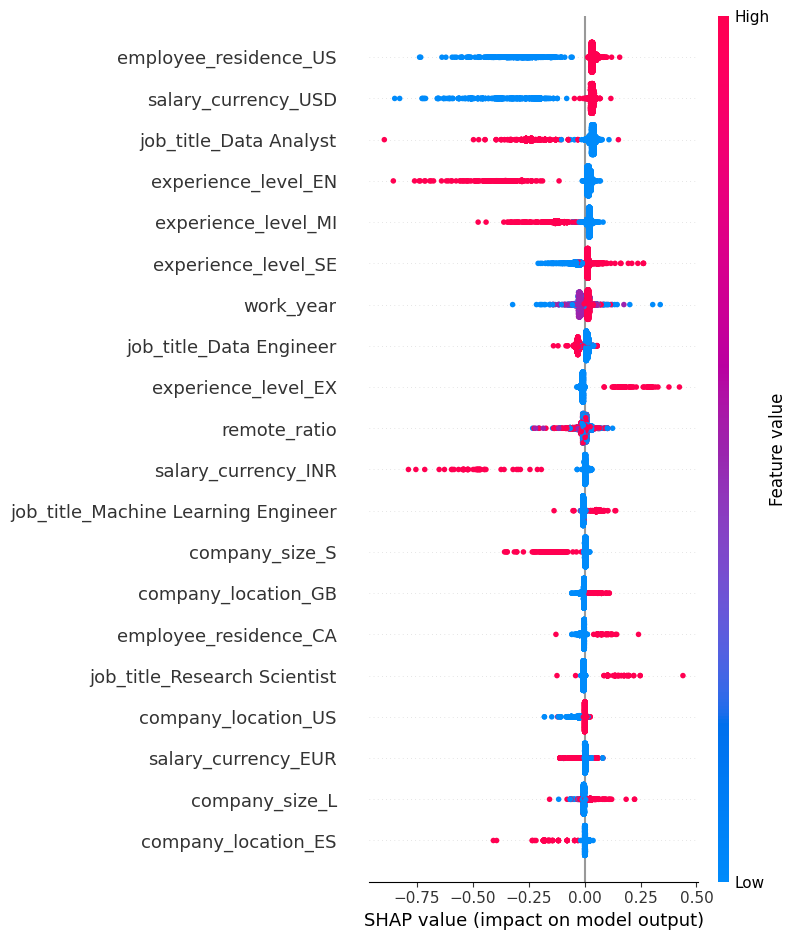

In [41]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_ohe)
shap.summary_plot(shap_values, X_ohe)

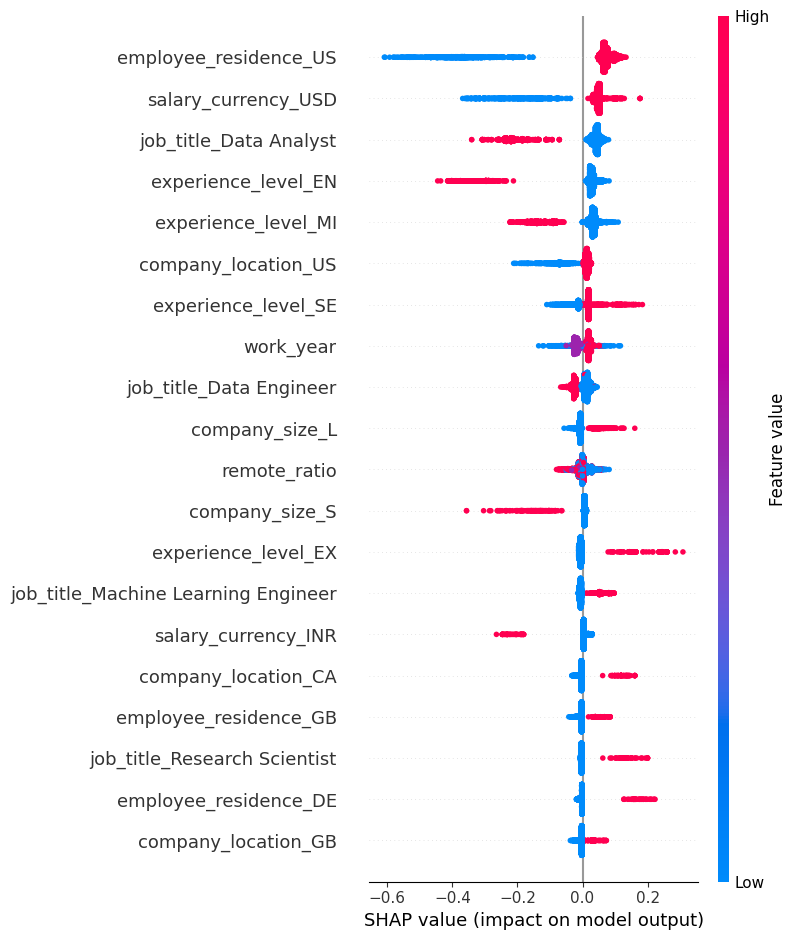

In [42]:
explainer = shap.Explainer(gbm)
shap_values = explainer(X_ohe)
shap.summary_plot(shap_values, X_ohe)

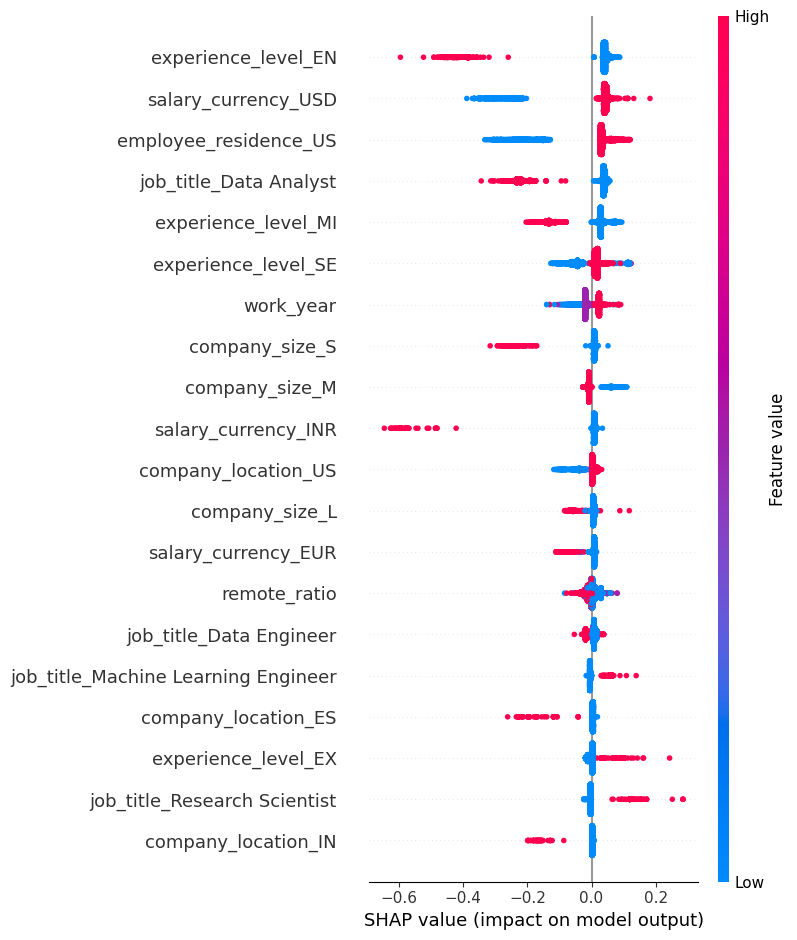

In [43]:
explainer = shap.Explainer(cat)
shap_values = explainer(X_ohe)
shap.summary_plot(shap_values, X_ohe)

положительно на зарплату влияет нахождение работника в US, опыт SE или EX, должность Research Scientist, при этом большой размер компании, доля работы удалённо неоднозначно влияют на зарплату

## Задание 7 (2 балла)
Придумайте признаки для улучшения качества моделей на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво каждой модели? Реализуйте признаки и проверьте улучшилось ли качество моделей. Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы

In [44]:
pd.DataFrame.from_dict(d, orient='index', columns=["ohe", "le", "te"])["ohe"]

xgb    (0.38, 49318.38)
gbm     (0.4, 50480.47)
cat    (0.37, 49585.84)
Name: ohe, dtype: object

In [45]:
data = X_ohe.copy()
data_test = X_test_ohe.copy()
data["SE_in_US"] = data["experience_level_SE"] * data["employee_residence_US"]
data_test["SE_in_US"] = data_test["experience_level_SE"] * data_test["employee_residence_US"]

data["EX_in_US"] = data["experience_level_EX"] * data["employee_residence_US"]
data_test["EX_in_US"] = data_test["experience_level_EX"] * data_test["employee_residence_US"]

In [46]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(data, y)
y_pred_xgb = xgb.predict(data_test)


gbm = lgb.LGBMRegressor(verbose=0, objective="poisson", random_state=42)
gbm.fit(data, y)
y_pred_gbm = gbm.predict(data_test)


cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(data, y, verbose=False)
y_pred_cat = cat.predict(data_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [47]:
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_xgb), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_xgb)**0.5, 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_gbm), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_gbm)**0.5, 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_cat), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_cat)**0.5, 2)}")

MAPE: 0.38, RMSE: 49665.05
MAPE: 0.4, RMSE: 50477.28
MAPE: 0.36, RMSE: 49569.77


нет значительных изменений

In [48]:
data = X_ohe.copy()
data_test = X_test_ohe.copy()
data["SE_in_US"] = data["experience_level_SE"] * data["employee_residence_US"] * data["company_size_M"]
data_test["SE_in_US"] = data_test["experience_level_SE"] * data_test["employee_residence_US"] * data["company_size_M"]

data["EX_in_US"] = data["experience_level_EX"] * data["employee_residence_US"] * data["company_size_M"]
data_test["EX_in_US"] = data_test["experience_level_EX"] * data_test["employee_residence_US"] * data["company_size_M"]

In [49]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(data, y)
y_pred_xgb = xgb.predict(data_test)


gbm = lgb.LGBMRegressor(verbose=0, objective="poisson", random_state=42)
gbm.fit(data, y)
y_pred_gbm = gbm.predict(data_test)


cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(data, y, verbose=False)
y_pred_cat = cat.predict(data_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [50]:
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_xgb), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_xgb)**0.5, 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_gbm), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_gbm)**0.5, 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_cat), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_cat)**0.5, 2)}")

MAPE: 0.38, RMSE: 49296.56
MAPE: 0.4, RMSE: 50543.93
MAPE: 0.37, RMSE: 50433.62


на XGBOOST повысилось незначительно качество

In [51]:
data["foreigner"] = df["employee_residence"] != df["company_location"] 
data_test["foreigner"] = df["employee_residence"] != df["company_location"]

In [52]:
xgb = XGBRegressor(objective='reg:tweedie', random_state=42)
xgb.fit(data, y)
y_pred_xgb = xgb.predict(data_test)


gbm = lgb.LGBMRegressor(verbose=0, objective="poisson", random_state=42)
gbm.fit(data, y)
y_pred_gbm = gbm.predict(data_test)


cat = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=42)
cat.fit(data, y, verbose=False)
y_pred_cat = cat.predict(data_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [53]:
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_xgb), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_xgb)**0.5, 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_gbm), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_gbm)**0.5, 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_cat), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_cat)**0.5, 2)}")

MAPE: 0.38, RMSE: 49675.55
MAPE: 0.4, RMSE: 50622.02
MAPE: 0.37, RMSE: 49938.56


добавление информации о том, иностранец ли сотрудник, только понизило качество

## Задание 8 (3 балла)
Напишите функцию для оптимизации гиперпараметров трёх моделей бустинга: xgboost, catboost и lightgbm. Функция должна работать максимально эффективно по времени и качеству (соответственно, полный перебор - самый тупой вариант)

В случае Catboost, используйте pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметры cat_features.

Подберите для каждой из моделей лучшие гиперпараметры. 

**по алгоритму из семинара:**

Выбираем относительно большую learning_rate ( 𝜂∈[0.05,0.3]
 ), подбираем оптимальное число деревьев для выбранного  𝜂
 
Настраиваем параметры деревьев, начиная с самых значимых 

Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

**функция тоже на основе функции modelfit из семинара**

In [54]:
def xgb_params(model, X_train, y_train):
        xgtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgboost.cv(
            model.get_xgb_params(),
            xgtrain,
            num_boost_round=model.get_params()["n_estimators"],
            nfold=5,
            metrics="rmse",
            early_stopping_rounds=50
        )
        model.set_params(n_estimators=cvresult.shape[0])
        
        params = {"max_depth": range(2, 10)}
        gs  = GridSearchCV(
        estimator=model, param_grid=params, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=5)

        gs.fit(X_train, y_train)

        model.set_params(max_depth=gs.best_params_["max_depth"])
        
        params = {"subsample": np.arange(0.1, 1, 0.1)}
        gs  = GridSearchCV(
        estimator=model, param_grid=params, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=5)

        gs.fit(X_train, y_train)

        model.set_params(subsample=gs.best_params_["subsample"])
        
        params = {"reg_lambda": [0.1, 1, 10, 100]}
        gs  = GridSearchCV(
        estimator=model, param_grid=params, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=5)

        gs.fit(X_train, y_train)

        model.set_params(reg_lambda=gs.best_params_["reg_lambda"])

In [55]:
xgb = XGBRegressor(
    learning_rate=0.3,
    n_estimators=150,
    objective='reg:tweedie',
    random_state=42,
    nthread=-1)
xgb_params(xgb, X_ohe, y)

In [56]:
xgb.set_params(learning_rate=0.003, n_estimators=xgb.get_params()["n_estimators"]*100)
print(xgb.get_params())
xgb.fit(X_ohe, y)
y_pred_xgb = xgb.predict(X_test_ohe)

print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_xgb), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_xgb)**0.5, 2)}")

{'objective': 'reg:tweedie', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.003, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 4800, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'nthread': -1}
MAPE: 0.38, RMSE: 49714.81


In [57]:
cat = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", 
                        "company_location", "company_size"]
catmod = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', cat_features=cat, random_state=42)
catmod.fit(X, y, verbose=False)
y_pred_cat = catmod.predict(X_test)

In [58]:
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_cat), 2)}, RMSE: {round(mean_squared_error(y_test, y_pred_cat)**0.5, 2)}")

MAPE: 0.4, RMSE: 50562.55


## Задание 9 (1 балл)

Сделайте выводы про модели бустинга, какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания

все модели без настройки справляются c примерно одинаковым качеством, самая быстрая модель -- LightGBM, CatBoost работает значительно дольше, все модели требуют аккуратного подбора параметров, CatBoost удобен тем, что можно не кодировать категориальные переменные